In [1]:
# Library Functions
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
import pickle
from tensorflow.keras.applications import NASNetMobile

In [ ]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Define tumor types
tumor_types = ['1no_tumor', 'glioma', 'meningioma', 'pituitary']

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Num GPUs Available:  1


In [ ]:
# Define directories
train_dir = '/content/drive/MyDrive/CNN_MODEL1/Dataset_41/Training'
val_dir = '/content/drive/MyDrive/CNN_MODEL1/Dataset_41/Validation'

In [ ]:
# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical',  # Change to categorical
    classes=tumor_types  # Adjust classes
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical',  # Change to categorical
    classes=tumor_types  # Adjust classes
)

Found 8582 images belonging to 4 classes.
Found 829 images belonging to 4 classes.


In [ ]:
# Define the model

base_model_nas = NASNetMobile(weights='imagenet', include_top=False, input_shape=(128, 128, 3), pooling='max')

# Define your model
model = Sequential([
    base_model_nas,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
with tf.device('/GPU:0'):
 history = model.fit(train_generator, epochs=7, validation_data=val_generator, shuffle=False)

print(f"\nTraining Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")

19993432/19993432 [==============================] - 0s 0us/step
Epoch 1/7
68/68 [==============================] - 2766s 40s/step - loss: 4.9696 - accuracy: 0.8774 - val_loss: 5.1090 - val_accuracy: 0.4270
Epoch 2/7
68/68 [==============================] - 928s 14s/step - loss: 1.4012 - accuracy: 0.9689 - val_loss: 2.1875 - val_accuracy: 0.3667
Epoch 3/7
68/68 [==============================] - 926s 14s/step - loss: 0.4950 - accuracy: 0.9854 - val_loss: 1.4506 - val_accuracy: 0.5464
Epoch 4/7
68/68 [==============================] - 938s 14s/step - loss: 0.2643 - accuracy: 0.9886 - val_loss: 1.5000 - val_accuracy: 0.6261
Epoch 5/7
68/68 [==============================] - 928s 14s/step - loss: 0.2530 - accuracy: 0.9923 - val_loss: 43.7841 - val_accuracy: 0.3546
Epoch 6/7
68/68 [==============================] - 929s 14s/step - loss: 0.3601 - accuracy: 0.9650 - val_loss: 8.1053 - val_accuracy: 0.2992
Epoch 7/7
68/68 [==============================] - 928s 14s/step - loss: 0.4635 - accur

In [ ]:
# Save the trained model
model_path = '/content/drive/MyDrive/CNN_MODEL1/NasNet/model/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
model.save(os.path.join(model_path, 'model_multiclass.keras'))

# Save the training history
history_path = '/content/drive/MyDrive/CNN_MODEL1/NasNet/history/'
if not os.path.exists(history_path):
    os.makedirs(history_path)
training_metrics = {
    'accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'],
}
with open(os.path.join(history_path, 'training_history_multiclass.pkl'), 'wb') as file:
    pickle.dump(training_metrics, file)

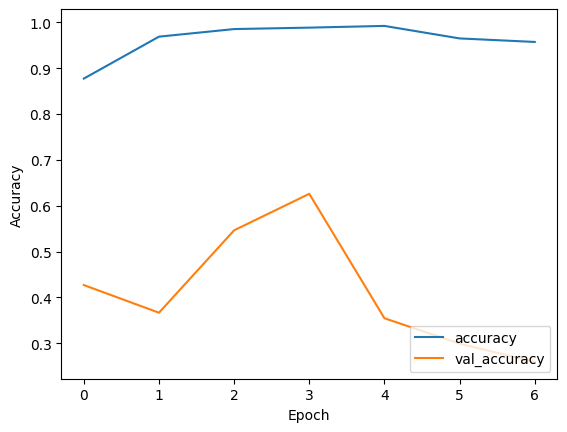

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# # Prediction of the result

import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
from google.colab import drive
drive.mount('/content/drive')

class ImageClassifier:
    def __init__(self, model_path):
        self.model = load_model(model_path)

    def preprocess_image(self, img_path):
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return img_array

    def classify_image(self, img_path):
        img_array = self.preprocess_image(img_path)
        predictions = self.model.predict(img_array)
        return predictions

    def plot_images_with_labels(self, image_folder):
        images = os.listdir(image_folder)
        num_images = len(images)

        fig, axes = plt.subplots(num_images, 2, figsize=(12, num_images * 4))

        for i, img_name in enumerate(images):
            img_path = os.path.join(image_folder, img_name)
            predictions = self.classify_image(img_path)
            original_image = image.load_img(img_path, target_size=(128, 128))

            axes[i, 0].imshow(original_image)
            axes[i, 0].axis('off')

            predicted_label = np.argmax(predictions[0])
            predicted_probability = predictions[0][predicted_label]
            tumor_types = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
            label_name = tumor_types[predicted_label]

            if label_name == 'glioma_tumor' or label_name == 'meningioma_tumor' or label_name == 'pituitary_tumor':
                label_assigned = 'Tumor Present'
            else:
                label_assigned = 'Tumor Not found'

            table_data = [['Prediction:', label_assigned], ['Probability:', f'{predicted_probability:.2f}']]
            axes[i, 1].axis('off')
            axes[i, 1].table(cellText=table_data, loc='center', colWidths=[0.5, 0.5])

        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    model_path = '/content/drive/MyDrive/CNN_MODEL1/NasNet/model/model_multiclass.keras'

    # Initialize the classifier with the model
    classifier = ImageClassifier(model_path)

    # Set the image folder
    image_folder = "/content/drive/MyDrive/CNN_MODEL1/Testing_9"

    # Plot images with labels
    classifier.plot_images_with_labels(image_folder)


Output hidden; open in https://colab.research.google.com to view.